<a href="https://colab.research.google.com/github/furkansepetci/MLP_Model_for_MNIST/blob/master/MLP_Model_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARIES

In [41]:
import tensorflow as tf
import pandas as pd
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

TRAINING PARAMETERS

In [42]:
learning_rate = (0.0005, 0.1, 0.1, 0.0005)
training_steps = 1875
step_interval = 75
batch_size = 256

MNIST DATASET PARAMETERS

In [43]:
num_features = 784 #total number of data features(from img shape:28*28)
num_classes = 10 #total number of class(because of 0-9 digits)

MODEL PARAMETERS

In [44]:
n_hidden_layer_1 = 512 #number of neurons in hidden layer 1
n_hidden_layer_2 = 128 #number of neurons in hidden layer 2

OPTIMIZERS

Here, we describe different optimization algorithms, which you can then use as objects to train a neural network model. Each optimization algorithm has different strategies for updating the weights, and you can experiment to determine which algorithm gives the best results.

In [45]:
optimizers = {
    "Adam": tf.keras.optimizers.Adam(learning_rate[0], beta_1=0.9, beta_2=0.99, epsilon=1e-7),
    "SGD": tf.keras.optimizers.SGD(learning_rate[1]),
    "SGD_with_Nesterov": tf.keras.optimizers.SGD(learning_rate[2], momentum=0.9, nesterov=True),
    "RMSprop": tf.keras.optimizers.RMSprop(learning_rate[3], rho=0.9, epsilon=1e-7)
}

DICTIONARY


results_dict is a dictionary used to store loss and accuracy results during training and testing. New data is added to this dictionary at each training and testing step and the results are then used for analysis.

In [46]:
results_dict = {
    'Prediction': [],
    'Optimizer': [],
    'Step': [],
    'Loss': [],
    'Accuracy': [],
}

PREPARE DATA


This part is used to load the MNIST dataset, pre-process it and make it available for training.

In [47]:
from tensorflow.keras.datasets import mnist #importing the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data() #loading the MNIST dataset

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)# Converting x_train and x_test data to Numpy arrays and setting the data type to 'float32'.
x_train, x_test = x_train.reshape(-1, num_features), x_test.reshape(-1, num_features) # Flatting images to 1-D vector of 784 features (28*28).

x_train, x_test = x_train/255. , x_test/255. #the pixel values of the x_train and x_test data are normalized between 0 and 1.
data_for_training = tf.data.Dataset.from_tensor_slices((x_train, y_train))#a TensorFlow dataset (Dataset) is created from the training data (x_train) and labels (y_train)
data_for_training = data_for_training.repeat().shuffle(len(x_train)).batch(batch_size).prefetch(1) #prepare and cache the dataset to be used during each batch

CREATE MLP MODEL

The class named 'MLP' defines a multilayer perception (MLP) model. This model consists of an input layer, two hidden layers and an output layer. For each layer the activation functions ReLU and dropout layers are used. The dropout layers used are customized. The activation of the output layer is specified by ReLU, softmax is not used during training, only during testing the output passes through softmax. He_uniform is used as kernel initilizer. The model processes input data and produces output via the 'call()' method. During training, dropout layers are used to avoid overfitting.

In [48]:
class MLP(Model):
    def __init__(self):
        super(MLP, self).__init__()

        self.hidden_layer_1 = layers.Dense(n_hidden_layer_1, activation=tf.nn.relu, kernel_initializer='he_uniform')
        self.dropout_1 = layers.Dropout(0.20)

        self.hidden_layer_2 = layers.Dense(n_hidden_layer_2, activation=tf.nn.relu, kernel_initializer='he_uniform')
        self.dropout_2 = layers.Dropout(0.25)

        self.out = layers.Dense(num_classes, activation=tf.nn.relu, kernel_initializer='he_uniform')

    def call(self, x, training=False):
        x = self.hidden_layer_1(x)
        x = self.dropout_1(x, training=training)
        x = self.hidden_layer_2(x)
        x = self.dropout_2(x, training=training)
        x = self.out(x)

        if not training: #This softmax layer is only active during the test phase
            x = tf.nn.softmax(x)

        return x

BACKPROPAGATION


'backpropagation' function performs backpropagation on a batch of data. In 'tf.GradientTape()', the loss between the output produced by the model and the actual labels is calculated. The trainable variables of the model are taken. Gradients are calculated according to the loss value. Using the optimization algorithm ('optimizer'), the gradients are applied to the trainable variables of the model.

In [49]:
def backpropagation(batch_x, batch_y, optimizer):
    with tf.GradientTape() as g:
        output = mlp(batch_x, training=True)
        loss = cross_entropy_loss(output, batch_y)

    trainable_variables = mlp.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

CALCULATE CROSS ENTROPY LOSS


The function 'cross_entropy_loss' calculates the cross entropy loss between predicted and actual tags. The actual tags are converted to data type 'tf.int64' and the cross entropy loss is calculated with 'tf.nn.sparse_softmax_cross_entropy_with_logits()'. The calculated loss values are averaged and returned. This is used to evaluate how well the model's predictions match the actual labels.

In [50]:
def cross_entropy_loss (pred, actual):
    actual = tf.cast(actual, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(actual, pred)
    return tf.reduce_mean(loss)

CALCULATE ACCURACY


The 'accuracy' function calculates the match rate between predicted and actual tags. The indices of the predicted classes are taken with 'tf.argmax(pred, 1)' and the actual labels with 'tf.int64'. Matching predictions are found with 'tf.equal()' and the ratio is returned.

In [51]:
def accuracy (pred, actual):
    num_correct = tf.equal(tf.argmax(pred,1), tf.cast(actual, tf.int64))
    return tf.reduce_mean(tf.cast(num_correct, tf.float32))

ADD RESULTS TO DICTIONARY


The function 'adding_to_the_dictionary' adds the training results to the 'results_dict' dictionary. 'test' indicates the type of result; 'optimizer_name' indicates the optimizer; 'step' indicates the number of steps; 'loss' indicates the loss value; 'acc' indicates the accuracy value.

In [52]:
def adding_to_the_dictionary(test, optimizer_name, step, loss, acc):
    results_dict['Prediction'].append(test)
    results_dict['Optimizer'].append(optimizer_name)
    results_dict['Step'].append(step)
    results_dict['Loss'].append(loss.numpy())
    results_dict['Accuracy'].append(acc.numpy())

PLOT GRAPH

In [53]:
def plot_graph(optimizer_name):
    # Filter the data
    filtered_df = result_df[result_df['Optimizer'] == optimizer_name]
    filtered_df_train = filtered_df[filtered_df['Prediction'] == 'Train']
    filtered_df_validation = filtered_df[filtered_df['Prediction'] == 'Validation']

    # Create the plot
    plt.figure(figsize=(20, 12))  # Adjust the size of the plot

    # Loss plot
    plt.plot(filtered_df_train['Step'], filtered_df_train['Loss'], label='Train Loss', marker='o', color='blue')

    # Accuracy plot
    plt.plot(filtered_df_train['Step'], filtered_df_train['Accuracy'], label='Train Accuracy', marker='o', color='red')
    plt.plot(filtered_df_validation['Step'], filtered_df_validation['Accuracy'], label='Validation Accuracy', marker='o', color='purple')

    plt.xlabel('Step')
    plt.ylabel('Loss & Accuracy')
    plt.title(f'Loss and Accuracy for {optimizer_name}')
    plt.legend()

    # Show the plot
    plt.grid()
    plt.show()

OPTIMIZATION PROCESS

A training loop is created for optimization operations. In each cycle, a new MLP model is created, hidden states from previous training are reset, batch processing is taken and the model is trained. At certain steps, the training and validation results are printed and added to the 'results_dict' dictionary. This allows optimizers to be compared.

In [54]:
for optimizer_name, optimizer in optimizers.items():
    print(f"\n\nTraining with {optimizer_name} optimizer:\n\n")

    mlp = MLP()
    mlp.reset_states()

    for step, (batch_x, batch_y) in enumerate(data_for_training.take(training_steps), 1):
        backpropagation(batch_x, batch_y, optimizer)

        if step % step_interval == 0:
            predictions_train = mlp(batch_x, training=True)
            loss = cross_entropy_loss(predictions_train, batch_y)
            acc = accuracy(predictions_train, batch_y)
            print(f"Training   : \tStep: {step:>4}  \tAccuracy: {acc:>7.4f}   \tLoss: {loss:>6.4f}, ")
            adding_to_the_dictionary("Train", optimizer_name, step, loss, acc)


            predictions_test = mlp(x_test, training=False)
            acc = accuracy(predictions_test, y_test)
            print(f"Validation : \tStep: {step:>4}  \tAccuracy: {acc:>7.4f}")
            adding_to_the_dictionary("Validation", optimizer_name, step, loss, acc)




Training with Adam optimizer:


Training   : 	Step:   75  	Accuracy:  0.9141   	Loss: 0.3861, 
Validation : 	Step:   75  	Accuracy:  0.9091
Training   : 	Step:  150  	Accuracy:  0.9102   	Loss: 0.3057, 
Validation : 	Step:  150  	Accuracy:  0.9367
Training   : 	Step:  225  	Accuracy:  0.9258   	Loss: 0.2337, 
Validation : 	Step:  225  	Accuracy:  0.9463
Training   : 	Step:  300  	Accuracy:  0.9570   	Loss: 0.1445, 
Validation : 	Step:  300  	Accuracy:  0.9545
Training   : 	Step:  375  	Accuracy:  0.9688   	Loss: 0.1470, 
Validation : 	Step:  375  	Accuracy:  0.9583
Training   : 	Step:  450  	Accuracy:  0.9453   	Loss: 0.2254, 
Validation : 	Step:  450  	Accuracy:  0.9634
Training   : 	Step:  525  	Accuracy:  0.9688   	Loss: 0.0973, 
Validation : 	Step:  525  	Accuracy:  0.9667
Training   : 	Step:  600  	Accuracy:  0.9570   	Loss: 0.1849, 
Validation : 	Step:  600  	Accuracy:  0.9661
Training   : 	Step:  675  	Accuracy:  0.9609   	Loss: 0.1218, 
Validation : 	Step:  675  	Accuracy:  0

SHOW THE GRAPH

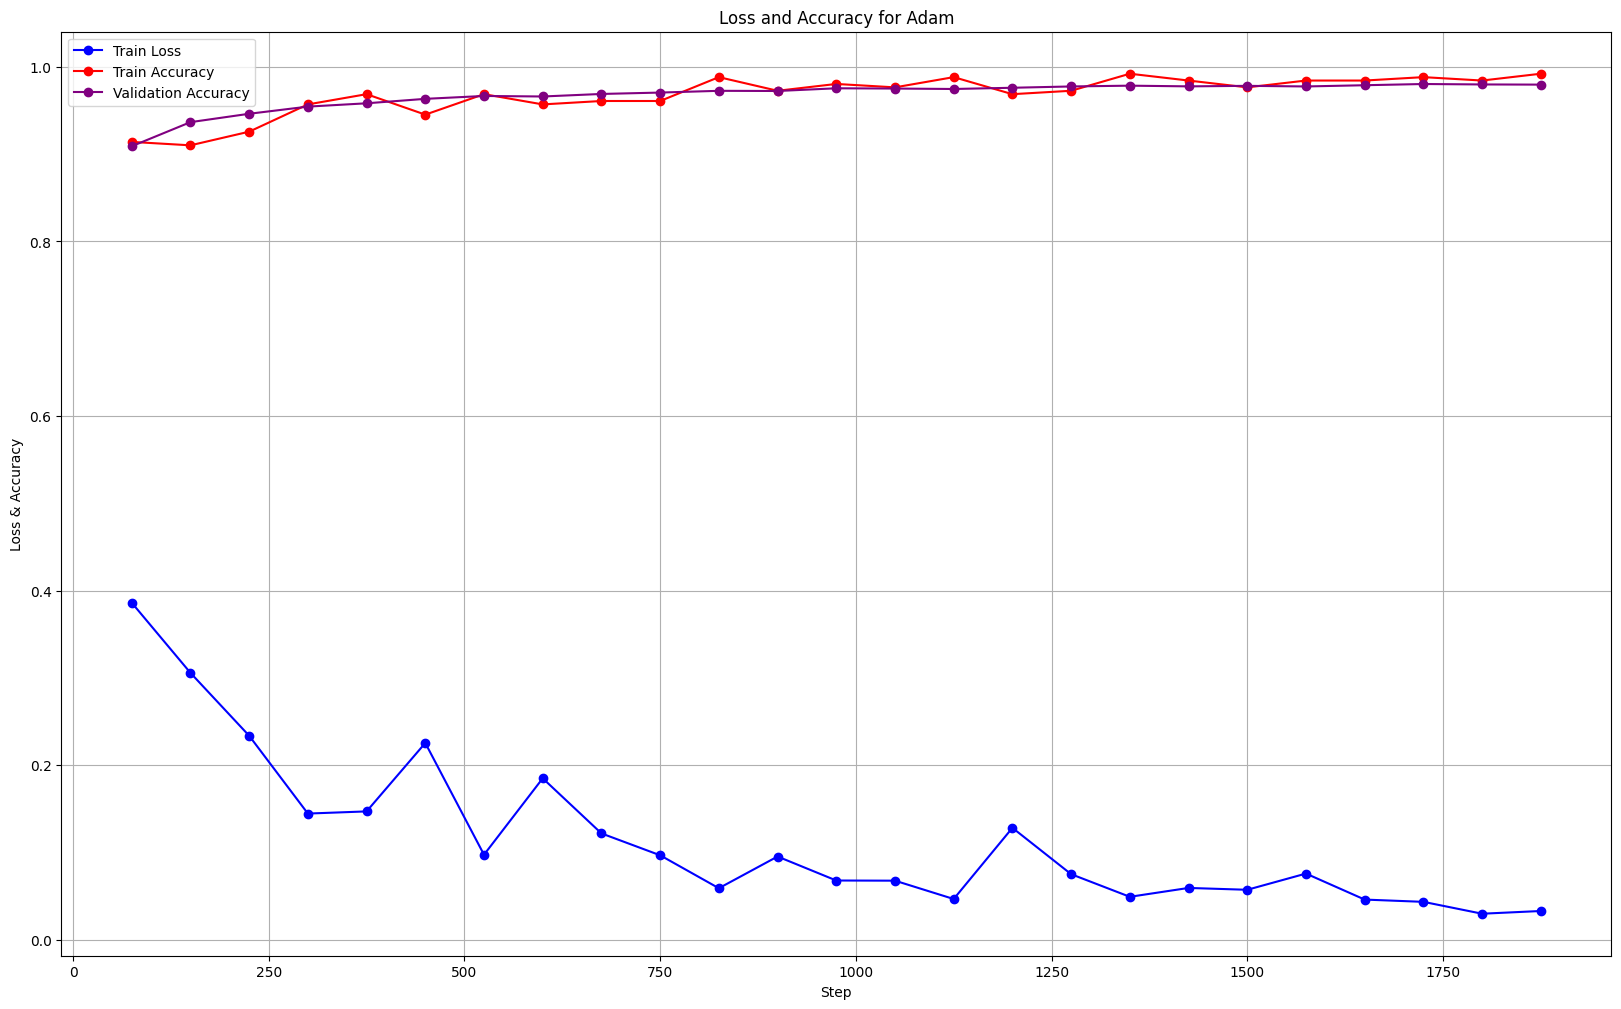

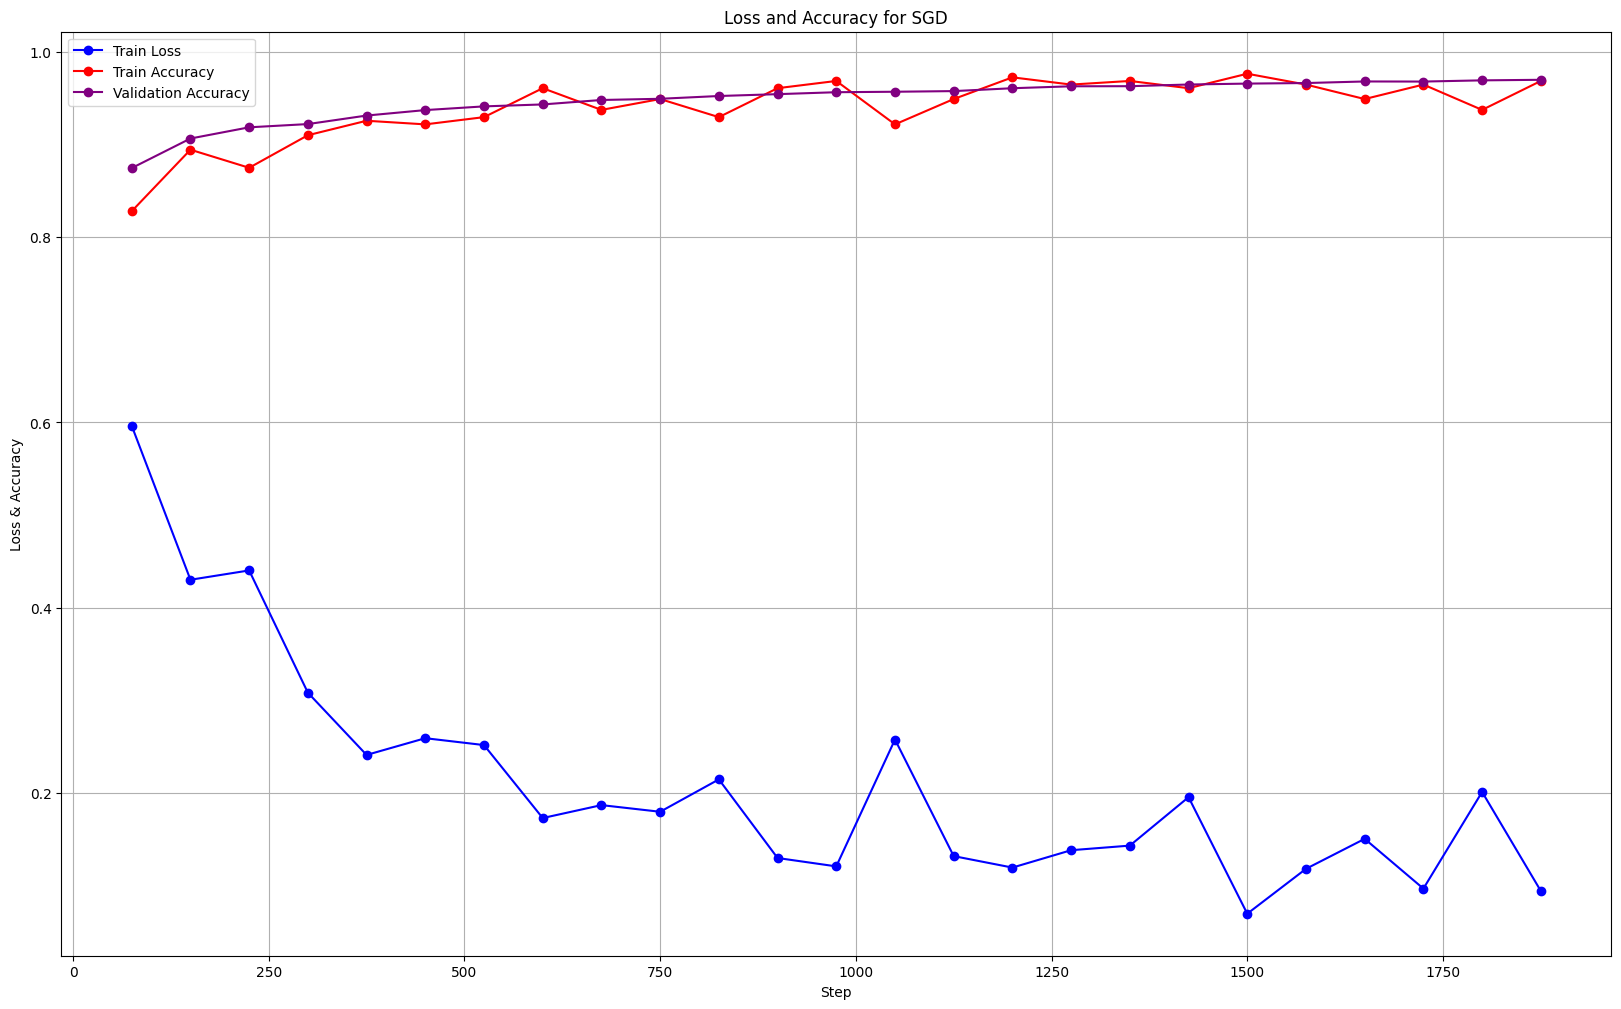

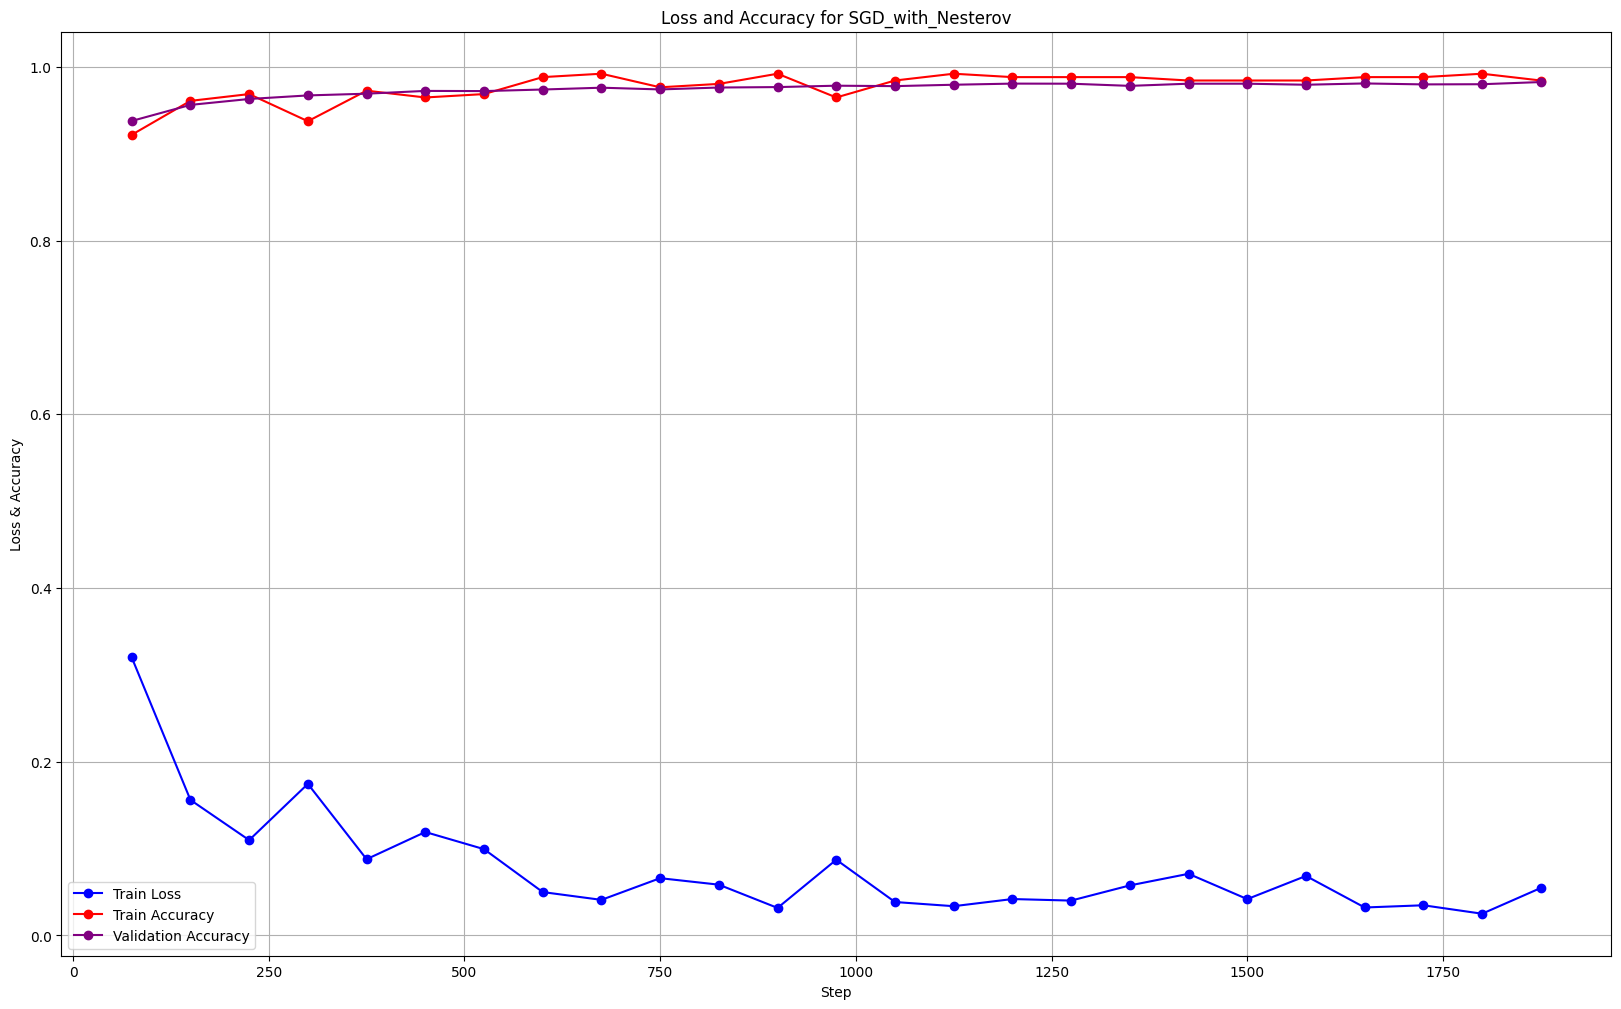

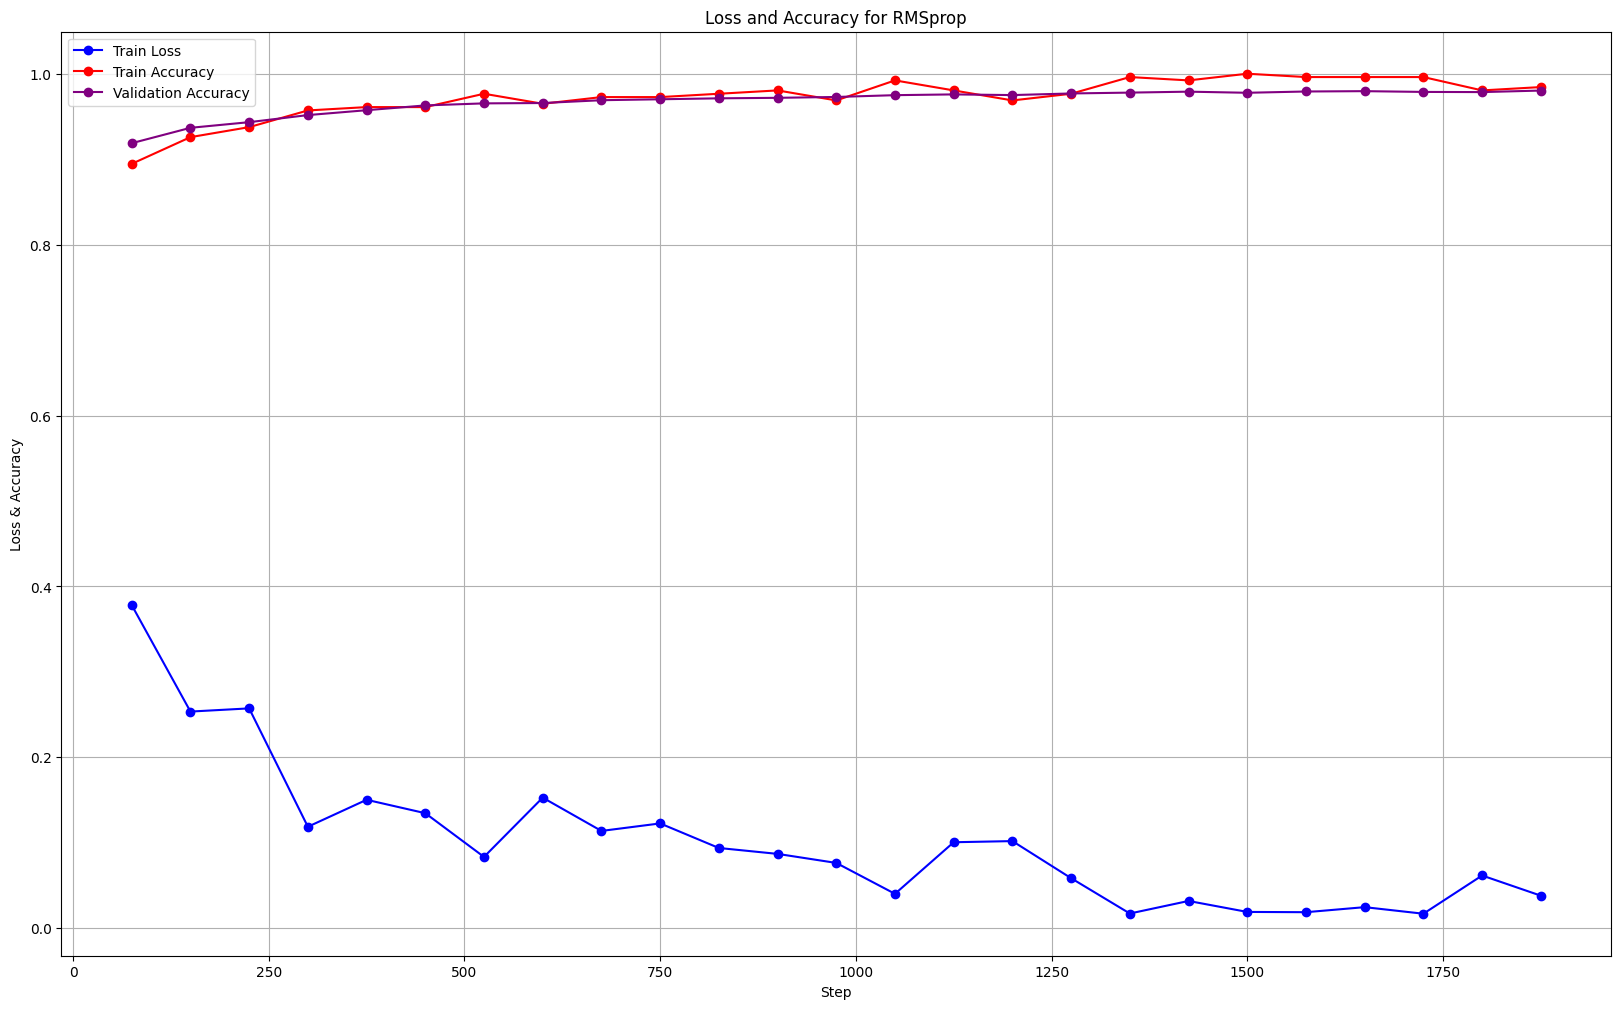

In [56]:
# Dataframe with results
result_df = pd.DataFrame(results_dict)

# Graph plotting cycle for each optimizer
for optimizer_name in optimizers.keys():
    plot_graph(optimizer_name)

CONCLUSION

Based on these results, we evaluate the performance of multilayer perceptron (MLP) models with two hidden layers trained using different optimization algorithms. First, we observe that the model trained with the "Adam" optimizer is highly successful. It managed to achieve a high accuracy with a low initial loss during training. Moreover, the accuracy score of the model increased steadily and eventually approached 97%. The model trained with the "SGD" optimizer initially had a slower training speed and needed more epochs, but eventually achieved an accuracy close to 97%. The model trained with the "SGD with Nesterov" optimizer started learning quickly and achieved an accuracy of over 98%. Finally, the model trained with the "RMSprop" optimizer progressed steadily and achieved an accuracy of over 98%.

The whole training process took a total of 8 epochs and similar results were obtained for each optimization algorithm. However, the model trained with the "SGD with Nesterov" optimizer learned faster than the others and achieved one of the highest accuracy scores. Therefore, we can say that the model trained with the "SGD with Nesterov" optimizer performs the best in this study.

In conclusion, this study investigated the effect of different optimization algorithms on the training performance of multilayer perceptron (MLP) models. The model trained with the "SGD with Nesterov" optimizer achieved the highest accuracy scores and provided faster learning than other optimization algorithms. Therefore, it is important to test different optimization strategies depending on the dataset and the problem, as each one may perform better under different conditions.
